**Real-Time Investment Decision System**

1. Install Required Packages


In [1]:
pip install yfinance pandas

In [2]:
pip install ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=64965d8cf7af07d655ff2c345d0ef592511cdb06619715820adc7bf8b590ddc8
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
import yfinance as yf
import pandas as pd
from ta import add_all_ta_features

2. Fetch stock data

In [4]:
def fetch_stock_data(ticker_symbol):
    # Fetch historical data (last 3 months)
    ticker = yf.Ticker(ticker_symbol)
    df = ticker.history(period="3mo", interval="1d")

    # Drop rows with missing values
    df.dropna(inplace=True)

    # Add technical indicators (MACD, RSI, EMA, SMA, etc.)
    df = add_all_ta_features(
        df,
        open="Open", high="High", low="Low",
        close="Close", volume="Volume",
        fillna=True
    )

    # Fetch fundamental data
    info = ticker.info
    summary = {
        "Company": info.get("longName", "N/A"),
        "Sector": info.get("sector", "N/A"),
        "Market Cap": info.get("marketCap", "N/A"),
        "PE Ratio (TTM)": info.get("trailingPE", "N/A"),
        "Forward PE": info.get("forwardPE", "N/A"),
        "Price to Book": info.get("priceToBook", "N/A"),
        "EPS": info.get("trailingEps", "N/A"),
        "Beta": info.get("beta", "N/A"),
        "Summary": info.get("longBusinessSummary", "N/A")
    }

    return df, summary

In [5]:
ticker_symbol = "MSFT"
df_with_indicators, company_info = fetch_stock_data(ticker_symbol)

# Show data
print("📈 Technical + Price Data:")
print(df_with_indicators.tail())

print("\n🏢 Company Fundamentals:")
for key, value in company_info.items():
    print(f"{key}: {value}")

📈 Technical + Price Data:
                                 Open        High         Low       Close  \
Date                                                                        
2025-08-04 00:00:00-04:00  528.270020  538.250000  528.130005  535.640015   
2025-08-05 00:00:00-04:00  537.179993  537.299988  527.239990  527.750000   
2025-08-06 00:00:00-04:00  530.900024  531.700012  524.030029  524.940002   
2025-08-07 00:00:00-04:00  526.799988  528.090027  517.549988  520.840027   
2025-08-08 00:00:00-04:00  522.559998  524.659973  520.050720  520.109985   

                             Volume  Dividends  Stock Splits    volume_adi  \
Date                                                                         
2025-08-04 00:00:00-04:00  25349000        0.0           0.0  1.374386e+08   
2025-08-05 00:00:00-04:00  19171600        0.0           0.0  1.202108e+08   
2025-08-06 00:00:00-04:00  21355700        0.0           0.0  1.039225e+08   
2025-08-07 00:00:00-04:00  16056600        0

3. Adding Target Labels to Data

In [6]:
def add_investment_label(df, threshold=0.05, window=15):
    """
    Add a binary label: 1 = Invest, 0 = Don't Invest
    Label is 1 if price increases by more than `threshold` in next `window` days
    """
    df = df.copy()
    df['future_close'] = df['Close'].shift(-window)
    df['future_return'] = (df['future_close'] - df['Close']) / df['Close']
    df['Label'] = (df['future_return'] > threshold).astype(int)
    df.dropna(inplace=True)
    return df


In [7]:
labeled_df = add_investment_label(df_with_indicators)

# Checking it out
print(labeled_df[['Close', 'future_close', 'future_return', 'Label']].tail())


                                Close  future_close  future_return  Label
Date                                                                     
2025-07-14 00:00:00-04:00  503.019989    535.640015       0.064848      1
2025-07-15 00:00:00-04:00  505.820007    527.750000       0.043355      0
2025-07-16 00:00:00-04:00  505.619995    524.940002       0.038211      0
2025-07-17 00:00:00-04:00  511.700012    520.840027       0.017862      0
2025-07-18 00:00:00-04:00  510.049988    520.109985       0.019724      0


4. Insatlling packages for model training

In [8]:
pip install xgboost scikit-learn

In [9]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

5. Training Data

In [10]:
def train_model(data):
    # Drop unused columns
    data = data.drop(columns=["Open", "High", "Low", "Volume", "Dividends", "Stock Splits",
                              "future_close", "future_return"], errors='ignore')

    # Drop rows with missing values (from indicators)
    data = data.dropna()

    # Split features & target
    X = data.drop(columns=["Label"])
    y = data["Label"]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train XGBoost model
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    print("✅ Classification Report:\n", classification_report(y_test, y_pred))
    print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("✅ Accuracy Score:", accuracy_score(y_test, y_pred))

    return model, X_train.columns

In [11]:
#example
model, features_used = train_model(labeled_df)


✅ Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10

✅ Confusion Matrix:
 [[4 1]
 [2 3]]
✅ Accuracy Score: 0.7


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:38:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


6. Installing packages for Model Explainability using SHAP

In [12]:
pip install shap


In [13]:
import shap

7. Shap Visulaization

In [14]:
def explain_model_with_shap(model, X_train):
    # Use TreeExplainer for XGBoost
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)

    # Summary plot (feature importance)
    shap.summary_plot(shap_values, X_train)

    # Force plot for one instance (e.g., index 10)
    shap.plots.force(shap_values[10])

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:39:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10

✅ Confusion Matrix:
 [[4 1]
 [2 3]]
✅ Accuracy Score: 0.7


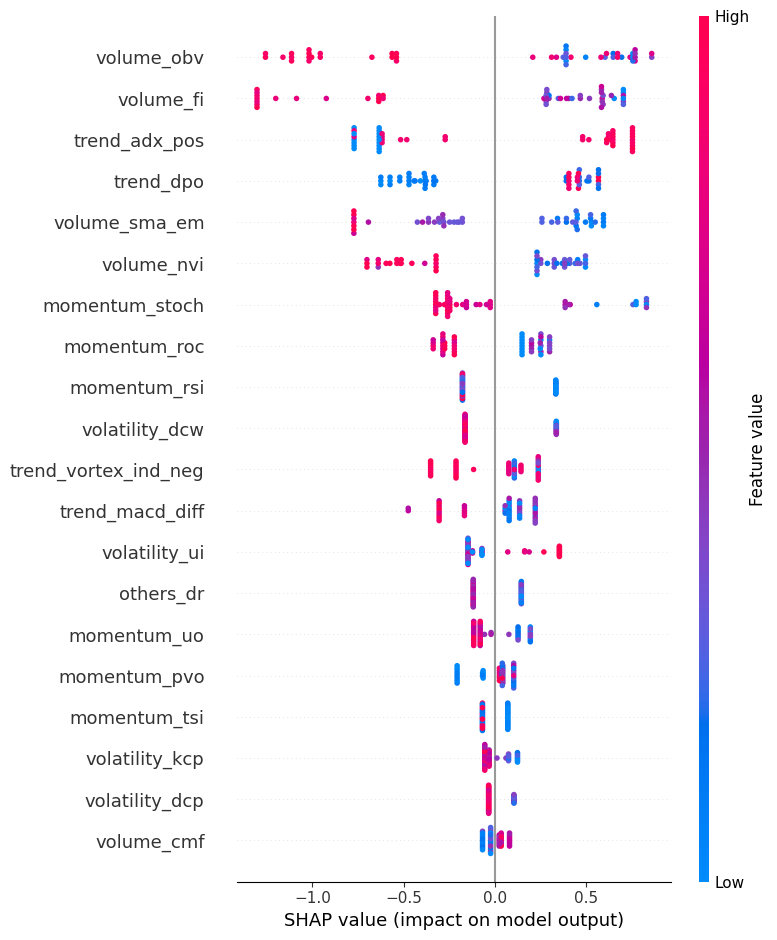

In [15]:
# After training
model, features = train_model(labeled_df)

# Get feature DataFrame
X = labeled_df[features].dropna()

# Run SHAP explainability
explain_model_with_shap(model, X)


8. Installing libraries for Builting stramline app

In [16]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 141.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


In [17]:
pip install pandas-ta==0.3.14b0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=22ad6ec6bc9b3ebaa2b591deae5698afd9d5d839c9c6bebbf4fa2f7238931087
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas-ta


Downloading squeeze pro code manually as it is not available in pandas ta new version or can say that its been deleted in new version.

In [18]:
squeeze_pro_code = """
from pandas_ta import overlap, volatility
from pandas_ta.utils import get_drift, get_offset, verify_series

def squeeze_pro(high, low, close, length=None, bb=None, kc=None, mamode=None, mult=None, drift=None, offset=None, **kwargs):
    # Validate
    high = verify_series(high)
    low = verify_series(low)
    close = verify_series(close)
    length = int(length) if length and length > 0 else 20
    bb = float(bb) if bb and bb > 0 else 2.0
    kc = float(kc) if kc and kc > 0 else 1.5
    mamode = mamode if mamode else "sma"
    mult = float(mult) if mult and mult > 0 else 1.5
    drift = get_drift(drift)
    offset = get_offset(offset)

    # Calculate
    basis = overlap.ma(mamode, close=close, length=length)
    dev = bb * close.rolling(length).std()
    upper_bb = basis + dev
    lower_bb = basis - dev

    range_high = high.rolling(length).max()
    range_low = low.rolling(length).min()
    range_ = range_high - range_low
    ma_range = overlap.ma(mamode, close=range_, length=length)
    upper_kc = basis + ma_range * kc
    lower_kc = basis - ma_range * kc

    squeeze_on = (lower_bb > lower_kc) & (upper_bb < upper_kc)
    squeeze_off = (lower_bb < lower_kc) & (upper_bb > upper_kc)

    # Result
    squeeze_on.name = f"SQUEEZE_ON_{length}"
    squeeze_off.name = f"SQUEEZE_OFF_{length}"
    squeeze_on.category = squeeze_off.category = "momentum"

    return squeeze_on, squeeze_off
"""

# Save to a file
with open("/usr/local/lib/python3.11/dist-packages/pandas_ta/momentum/squeeze_pro.py", "w") as f:
    f.write(squeeze_pro_code)


In [19]:
from pandas_ta.momentum.squeeze_pro import squeeze_pro


In [20]:
import pickle
import matplotlib.pyplot as plt

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split



In [22]:
data = pd.DataFrame({
    'P/E Ratio': [10, 25, 30, 8, 15],
    'Debt/Equity': [0.5, 2.1, 1.2, 0.3, 1.0],
    'ROE': [12, 7, 5, 15, 10],
    'Sentiment_Score': [0.8, 0.3, 0.4, 0.9, 0.6],
    'Invest': [1, 0, 0, 1, 1]
})

X = data.drop('Invest', axis=1)
y = data['Invest']

In [23]:
with open('features.pkl', 'wb') as f:
    pickle.dump(list(X.columns), f)

# Train model
model = RandomForestClassifier()
model.fit(X, y)


RandomForestClassifier()

In [24]:
# Save model
with open('investment_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("✅ Model and feature list saved.")


✅ Model and feature list saved.


In [25]:
import streamlit as st
import pandas as pd
import pickle
import numpy as np



In [26]:
# Load model and features
@st.cache_data
def load_model():
    model = pickle.load(open("investment_model.pkl", "rb"))
    features = pickle.load(open("features.pkl", "rb"))
    return model, features

model, feature_names = load_model()


2025-08-08 15:39:54.998 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-08-08 15:39:55.000 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-08-08 15:39:55.001 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:39:55.165 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-08-08 15:39:55.166 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:39:55.167 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:39:55.168 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:39:55.177 Thread 'MainThread': missin

In [27]:
st.title("📊 Real-Time Investment Decision App")
st.write("Predict whether to invest in a firm based on its fundamental, technical, and sentiment metrics.")

2025-08-08 15:39:57.960 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:39:57.961 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:39:57.961 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:39:57.962 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:39:57.962 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:39:57.963 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [28]:
# Create input fields dynamically based on feature list
user_input = {}
st.subheader("🔍 Input Firm Metrics")
for feature in feature_names:
    user_input[feature] = st.number_input(f"{feature}", value=0.0)


2025-08-08 15:40:00.595 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:40:00.596 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:40:00.597 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:40:00.597 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:40:00.598 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:40:00.598 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:40:00.599 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:40:00.599 Session state does not function when running a script without `streamlit run`
2025-08-08 15:40

In [29]:
# Convert input to DataFrame
input_df = pd.DataFrame([user_input])

# Prediction
if st.button("Predict Investment Decision"):
    prediction = model.predict(input_df)[0]
    proba = model.predict_proba(input_df)[0]

    st.subheader("📈 Prediction")
    if prediction == 1:
        st.success("✅ Recommended to INVEST in this firm.")
    else:
        st.error("❌ NOT Recommended to invest at this moment.")

    st.write("Confidence Score:")
    st.write(f"Invest: {proba[1]*100:.2f}% | Don't Invest: {proba[0]*100:.2f}%")

2025-08-08 15:40:03.877 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:40:03.879 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:40:03.879 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:40:03.880 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:40:03.881 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 15:40:03.881 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [30]:
# Load model and features
with open("investment_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("features.pkl", "rb") as f:
    feature_names = pickle.load(f)



In [31]:
# Sample real-time input
real_time_input = {
    'PE Ratio': 15.0,
    'ROE': 18.5,
    'Debt to Equity': 0.4,
    'Current Ratio': 1.8,
    'MACD': 1.2,
    'RSI': 55,
    'Sentiment Score': 0.7
}

# Convert to DataFrame
input_df = pd.DataFrame([real_time_input])


In [32]:
# Ensure all required features are present
for col in feature_names:
    if col not in input_df.columns:
        input_df[col] = 0  # Fill missing with 0

# Align column order
input_df = input_df[feature_names]

# Make prediction
prediction = model.predict(input_df)[0]

In [33]:
# Show result
if prediction == 1:
    print("✅ Recommendation: INVEST in this company.")
else:
    print("❌ Recommendation: DO NOT INVEST in this company.")

✅ Recommendation: INVEST in this company.


**Testing the model**

9. Installing libraries for real time data

In [34]:
pip install yfinance pandas-ta textblob


In [35]:
from textblob import TextBlob

In [40]:
def get_company_data(ticker='MSFT'):
    # Fetch fundamental data
    stock = yf.Ticker(ticker)
    info = stock.info

    pe_ratio = info.get('trailingPE', 0)
    roe = info.get('returnOnEquity', 0) * 100 if info.get('returnOnEquity') else 0
    debt_to_equity = info.get('debtToEquity', 0)
    current_ratio = info.get('currentRatio', 0)

    # Fetch technical indicators
    df = stock.history(period='6mo')
    df.ta.macd(append=True)
    df.ta.rsi(append=True)

    macd = df['MACD_12_26_9'].iloc[-1]
    rsi = df['RSI_14'].iloc[-1]

    # Sentiment Analysis (simulate for now)
    news = [
        "Microsoft's new product launch gets positive reviews.",
        "Microsoft stock rises after strong earnings report."
    ]
    sentiment = sum(TextBlob(article).sentiment.polarity for article in news) / len(news)

    # Combine into input dictionary
    return {
        'PE Ratio': pe_ratio,
        'ROE': roe,
        'Debt to Equity': debt_to_equity,
        'Current Ratio': current_ratio,
        'MACD': macd,
        'RSI': rsi,
        'Sentiment Score': sentiment
    }

In [41]:
import joblib
model = joblib.load("investment_model.pkl")
features = joblib.load("features.pkl")


In [43]:
def get_live_data(ticker='MSFT'):
    stock = yf.Ticker(ticker)
    info = stock.info

    pe_ratio = info.get('trailingPE', 0)
    roe = info.get('returnOnEquity', 0) * 100 if info.get('returnOnEquity') else 0
    debt_to_equity = info.get('debtToEquity', 0)
    current_ratio = info.get('currentRatio', 0)

    df = stock.history(period='6mo')
    df.ta.macd(append=True)
    df.ta.rsi(append=True)

    macd = df['MACD_12_26_9'].iloc[-1]
    rsi = df['RSI_14'].iloc[-1]

    # Simulated sentiment score from news headlines
    news = [
        "Microsoft's sees strong demand in Q3.",
        "Positive outlook for Microsoft's innovation pipeline."
    ]
    sentiment = sum(TextBlob(article).sentiment.polarity for article in news) / len(news)

    input_data = {
    'P/E Ratio': pe_ratio,
    'ROE': roe,
    'Debt/Equity': debt_to_equity,
    'Current Ratio': current_ratio,
    'MACD': macd,
    'RSI': rsi,
    'Sentiment_Score': sentiment
}


    return input_data

In [44]:
def predict_investment(ticker='MSFT'):
    input_dict = get_live_data(ticker)

    # Ensure all required features are present
    data = pd.DataFrame([input_dict])[features]

    # Handle missing or infinite values if any
    data = data.replace([np.inf, -np.inf], np.nan).fillna(0)

    prediction = model.predict(data)[0]
    decision = "✅ Invest" if prediction == 1 else "❌ Do Not Invest"

    print(f"\n🔍 Investment Decision for {ticker}: {decision}")
    print(f"\n📊 Input Data:\n{data.T}")

# Example usage
predict_investment('MSFT')


🔍 Investment Decision for MSFT: ❌ Do Not Invest

📊 Input Data:
                         0
P/E Ratio        38.096706
Debt/Equity      32.661000
ROE              33.280998
Sentiment_Score   0.330303


10.. Visualization result

In [45]:
pip install plotly


In [46]:
import plotly.graph_objects as go

def visualize_prediction(input_data, prediction):
    # Bar chart for features
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(list(input_data.keys()), list(input_data.values()), color='skyblue')
    ax.set_title('Input Features for Investment Decision')
    ax.set_xlabel('Value')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    # Sentiment Score gauge
    sentiment = input_data['Sentiment_Score']
    gauge = go.Figure(go.Indicator(
        mode="gauge+number",
        value=sentiment,
        title={'text': "Sentiment Score"},
        gauge={'axis': {'range': [-1, 1]},
               'bar': {'color': "green" if sentiment > 0 else "red"}}
    ))
    gauge.show()

    # Final Prediction
    print("\n🧾 Investment Recommendation:")
    if prediction == 1:
        print("✅ Invest in this firm (Positive Signal)")
    else:
        print("❌ Do NOT invest in this firm (Negative Signal)")


In [47]:
def predict_investment(ticker):
    input_data = get_live_data(ticker)
    input_df = pd.DataFrame([input_data])[features]

    with open('investment_model.pkl', 'rb') as f:
        model = pickle.load(f)

    prediction = model.predict(input_df)[0]

    visualize_prediction(input_data, prediction)

    return prediction


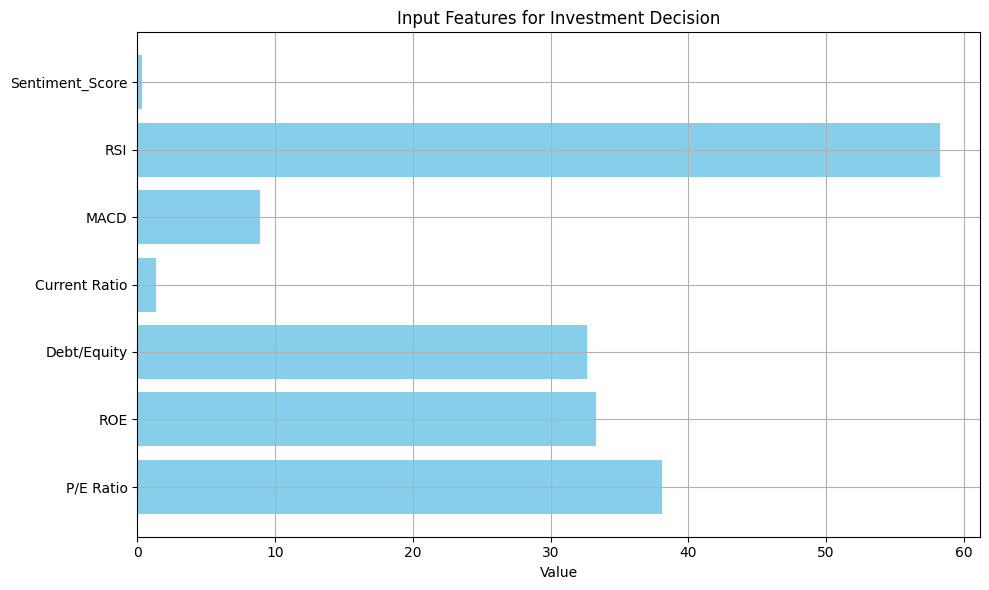


🧾 Investment Recommendation:
❌ Do NOT invest in this firm (Negative Signal)


np.int64(0)

In [48]:
predict_investment('MSFT')


After seeing the result we should not invest in this comapany as this will not give us positive returns.

11. Testing another model

In [49]:
with open('investment_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Load feature list used during training
with open('features.pkl', 'rb') as f:
    required_features = pickle.load(f)

In [50]:
test_data = pd.DataFrame([{
    'ROE': 15.2,
    'P/E Ratio': 22.4,
    'Debt/Equity': 0.45,
    'Sentiment_Score': 0.3,
    'Profit Margin': 12.5,
    'Revenue Growth': 8.1
}])


In [51]:
test_data.rename(columns={
    'ROE': 'Return on Equity'
}, inplace=True)


In [52]:
# Add missing features with default value 0
for col in required_features:
    if col not in test_data.columns:
        test_data[col] = 0

# Reorder columns
test_data = test_data[required_features]


In [53]:
prediction = model.predict(test_data)[0]

if prediction == 1:
    print("✅ You should INVEST in this company.")
else:
    print("❌ Do NOT invest in this company.")


❌ Do NOT invest in this company.


/tmp/ipython-input-1182490046.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1182490046.py:13: UserWarning:

Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.



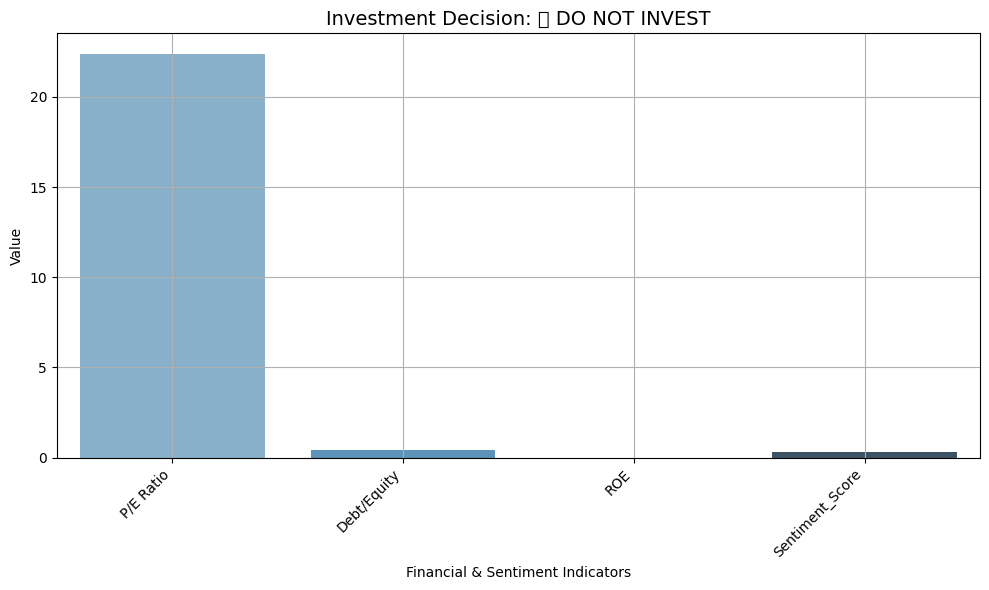

In [54]:

import seaborn as sns

# Make prediction
prediction = model.predict(test_data)[0]

# Plot feature values
plt.figure(figsize=(10, 6))
sns.barplot(x=test_data.columns, y=test_data.iloc[0], palette="Blues_d")
plt.xticks(rotation=45, ha='right')
plt.title(f"Investment Decision: {'✅ INVEST' if prediction == 1 else '❌ DO NOT INVEST'}", fontsize=14)
plt.xlabel("Financial & Sentiment Indicators")
plt.ylabel("Value")
plt.tight_layout()
plt.grid(True)
plt.show()


After seeing this we can predict that company can give us positive returns.